# CNN for Image Classification

In this lab, you are given a dataset containing 6,000 pictures of cats and dogs (3,000 cats, 3,000 dogs) and asked to train a classifier built upon Convolutional Neural Networks (ConvNets) to classify images as "dogs" or "cats".

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import keras
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


### Exercise 1 
Split the dataset by selecting 4,800 pictures for training, 600 for validation, and 600 for testing.

Full data value counts:
1    3000
0    3000
Name: Label, dtype: int64 

Train value counts: 
 0    2420
1    2380
Name: Label, dtype: int64 



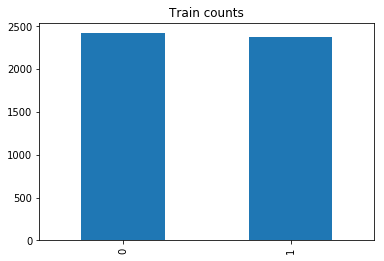

Validation value counts: 
 1    317
0    283
Name: Label, dtype: int64 



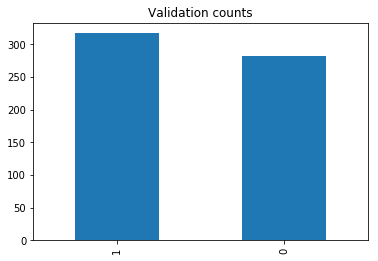

Test value counts: 
 1    303
0    297
Name: Label, dtype: int64 



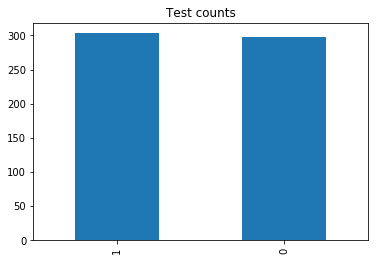

In [2]:
img_width = 50
img_height = 50
num_classes = 2
DATA_DIR = './data/'
image_filenames = [DATA_DIR+i for i in os.listdir(DATA_DIR)] # use this for full dataset

# Split the data in three sets, 80% for training, 10% for validation and 10% for testing
# make sure that the image filenames have a fixed order before shuffling
# Add your code here

from sklearn.utils import shuffle 

import pandas as pd  # for storing data in a dataframe

""" Sorts images """
image_filenames.sort()


""" Fetching Image Labels """
# Stores image labels in a list
# cats = 0, dogs = 1

labels = []  # stores image labels here
for image in image_filenames:
    if image.startswith("./data/cat"):
        labels.append("0")
    elif image.startswith("./data/dog"):
        labels.append("1")


""" Data Exploration """
# Initial data exploration
#'Data is stored in a pandas dataframe 

df = pd.DataFrame({"filename": image_filenames, "Label": labels})  # dataframe to store the data

# quick look at data
df.head()
df.tail()

# prints the value counts of the number of cats and dogs in the data set
print("Full data value counts:")
print(df['Label'].value_counts(), "\n")


### Analysis ###
# There are 6000 images in the data set
# The data set has an equal number of cats and dogs
# 3000 cats and 3000 dogs


""" Setting random seed """
# Sets the seed for reproducibility of results

SEED = 1234  # This can be any number
np.random.seed(SEED)


""" Shuffling dataframe """
# Data is shuffled to ensure fair test

# Shuffled data is stored in the same dataframe for performance and memory reasons
df = shuffle(df, random_state=SEED)  # shuffled using the same seed as before


""" Splitting data into train, validation and test """
# Splits the data and stores them in separate dataframes

train = df[:4800]  # 4800 images for train
val = df[4800:5400]  # 600 images for validation
test = df[5400:]  # 600 images for test


""" Exploring train, validation and test data """
# Verifying the data in the new dataframes 

print("Train value counts:", "\n", train['Label'].value_counts(), "\n")
pd.value_counts(train['Label']).plot.bar()
plt.title("Train counts")
plt.show()

print("Validation value counts:", "\n", val['Label'].value_counts(), "\n")
pd.value_counts(val['Label']).plot.bar()
plt.title("Validation counts")
plt.show()

print("Test value counts:", "\n", test['Label'].value_counts(), "\n")
pd.value_counts(test['Label']).plot.bar()
plt.title("Test counts")
plt.show()


### Analysis ###
# Overall the train and test data sets show there is an almost equal amount of cats and dogs.
# The validation set shows there are a few more dogs than cats.
# This difference is not huge so we can proceed as it is.




### Exercise 2
Train a Convolutional Neural Network (ConvNet) on the training set. The general structure of the ConvNet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers. A Conv2D layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. A MaxPooling2D layer is used to downscale input in both the vertical and horizontal dimensions.

In [3]:
# Add your code here

def read_img(img_path):
    """
    Reads and resizes the image
    """
    img = cv2.imread(img_path)
    return np.array(cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC))


""" Reading images in all dataframes """
# Reads the images and stores the data in a new column

#train["img"] = train["filename"].apply(read_img)
#val["img"] = val["filename"].apply(read_img)
#test["img"] = test["filename"].apply(read_img)


""" Fetching image shape """
# Verifying the image shape
"""
This section is commented out because it is not required to read all images with cv2
"""

# Checking single 
#img_shape = test["img"].iloc[0].shape

#print(img_shape)

## Checking all images
#train_shapes = set(i.shape for i in train["img"])
#val_shapes = set(i.shape for i in val["img"])
#test_shapes = set(i.shape for i in test["img"])
#
#shapes = test_shapes.union(val_shapes, train_shapes)
#print(shapes)


### Result ###
# All images have a shape of (50,50,3)


""" Fetching image shape """
# Verifying the image shape

# Checking single 
img_shape = read_img(test["filename"].iloc[0]).shape

print("\n", "Image shape is: ")
print(img_shape, "\n")


### Result ###
# All images have a shape of (50,50,3)


""" Building the CNN """
# Bulding an initial simple CNN. In the later section more features will be added.

# CNN is initialised
cnn = Sequential()

# First stack in CNN
cnn.add(Conv2D(32, (3, 3), input_shape=img_shape, activation='relu'))  # covolution layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling layer

# Second stack
cnn.add(Conv2D(32, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
cnn.add(Flatten())

# Fully connected
cnn.add(Dense(16)) 
cnn.add(Activation("relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation("sigmoid"))

# Compile
cnn.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])


""" Data Augmentation """
# Generates new images that are altered to prevent overfitting

# Training data will use this 
train_img_gen = ImageDataGenerator(
        rescale = 1./255,  # resizes
        shear_range = 0.2,  # 
        zoom_range = 0.2,
        horizontal_flip = True
        )

# Validation and test data will use this
test_img_gen = ImageDataGenerator(rescale = 1./255)  # Only need to rescale

# Train images generated
train_gen = train_img_gen.flow_from_dataframe(
        dataframe = train,
        directory = None,
        x_col = "filename",
        y_col = "Label",
        target_size = (img_width, img_height),
        class_mode = "binary",
        seed = SEED
        )

# Validation images generated
val_gen = test_img_gen.flow_from_dataframe(
        dataframe = val,
        directory = None,
        x_col = "filename",
        y_col = "Label",
        target_size = (img_width, img_height),
        class_mode = "binary",
        seed = SEED
        )

# Test images generated
test_gen = test_img_gen.flow_from_dataframe(
        dataframe = test,
        directory = None,
        x_col = "filename",
        y_col = "Label",
        target_size = (img_width, img_height),
        class_mode = "binary",
        shuffle = False,
        batch_size = 1
        )
#
#test_gen = test_img_gen.flow_from_dataframe(
#        dataframe = test,
#        directory = None,
#        x_col = "filename",
#        y_col = None,
#        target_size = (img_width, img_height),
#        class_mode = None,
#        shuffle = False,
#        batch_size = 1
#        )



### Analysis ###
# All generators successfully found the correct number of images.
# Train Found 4800 images belonging to 2 classes.
# Validation Found 600 images belonging to 2 classes.
# Test Found 600 images belonging to 2 classes.


""" Fitting model """
# Fitting initial model using training data and validating it on validation data

batch = 32  # standard and suitable for this project

model_1 = cnn.fit_generator(
        train_gen,
        epochs = 20,  # fine for this project
        steps_per_epoch = len(train_gen.filenames) // batch,  # set as advised by keras manual 
        validation_data = val_gen,
        validation_steps = len(val_gen.filenames) // batch,  # set as advised by keras manual
        shuffle = False
        )


""" Fetching predictions on test set """

# generating predictions 
preds = cnn.predict_generator(
        test_gen,
        steps = len(test_gen.filenames)
        )


""" Adding predictions to test dataframe """

# adding predictions to test df
test["probs"] = preds

# threshold to determine where predication is cat or dog
threshold = 0.5

# transforming prediction into readable labels to compare with labels column
test['preds'] = np.where(test['probs'] > threshold, "1","0")




 Image shape is: 
(50, 50, 3) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Found 4800 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
150/150 [==============================] - 53s 356ms/step - loss: 0.6947 - acc: 0.5131 - val_loss: 0.6910 - val_acc: 0.5885
Epoch 2/20
150/150 [==============================] - 13s 88ms/step - loss: 0.6852 - acc: 0.5348 - val_loss: 0.6857 - val_acc: 0.5845
Epoch 3/20
150/150 [==============================] - 14s 92ms/step - loss: 0.6685 - acc: 0.5992 - val_loss: 0.6728 - val_acc: 0.6303
Epoch 4/20
150/150 [==============================] - 14s 93ms/step - loss: 0.6644 - acc: 0.6160 - val_loss: 0.6526 - val_acc: 0.6496
Epoch 5/20
150

G:\Software\Python\anaconda_dist\lib\site-packages\ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
G:\Software\Python\anaconda_dist\lib\site-packages\ipykernel_launcher.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Exercise 3

Output the training/validation loss and accuracy curves. Also print the classification results (e.g., classification accuracy, confusion matrix, precision-recall curves and/or ROC curves) on the test set.

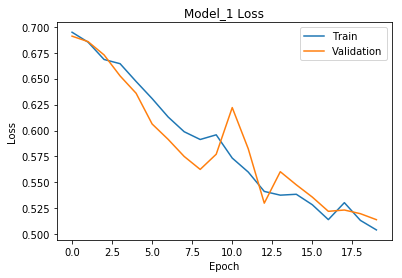

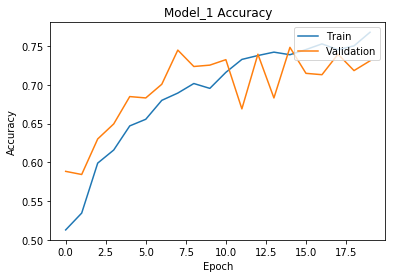

Printing classification results on test set 

Initial accuracy on test set is:  0.7333333333333333 

Classification report:  

              precision    recall  f1-score   support

           0       0.82      0.59      0.69       297
           1       0.68      0.87      0.77       303

   micro avg       0.73      0.73      0.73       600
   macro avg       0.75      0.73      0.73       600
weighted avg       0.75      0.73      0.73       600

Confusion Matrix:  

[[175 122]
 [ 38 265]]


G:\Software\Python\anaconda_dist\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


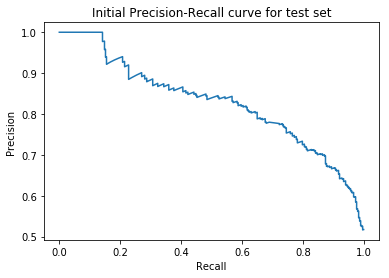

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve

# Add your code here

from sklearn.metrics import accuracy_score  # used to calculate accuracy 

""" Train and validation loss curves """

plt.plot(model_1.history['loss'])
plt.plot(model_1.history['val_loss'])
plt.title('Model_1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Results ###
# The Validation loss fluctuates a lot more than  the training loss curve.
# For the majority of the time the validation loss curve stays below the training curve.
# This is an indication of underfitting.


""" Train and validation accuracy curves """

plt.plot(model_1.history['acc'])
plt.plot(model_1.history['val_acc'])
plt.title('Model_1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Results ###
# The Validation accuracy fluctuates a lot more than  the training accuracy curve.
# For the majority of the time the validation accuracy curve stays above the training curve.
# This is an indication of underfitting.

""" Classification results on test set """

print("Printing classification results on test set", "\n")

### accuracy score ###
initial_score = accuracy_score(test["Label"], test["preds"])
print("Initial accuracy on test set is: ", initial_score, "\n")

# Gave accuracy of ~ 0.703. Which is really good for initial model

### classification report ###
print("Classification report: ", "\n")
print(classification_report(test["Label"], test["preds"]))

# Cat f1 score = 0.63. This is good 
# Dog f1 score = 0.75. This is really good.
# Overall good f1 scores

### confusion matrix ###
print("Confusion Matrix: ", "\n")
print(confusion_matrix(test["Label"], test["preds"], labels=["0", "1"]))

### precision recall ###
test["binary_labels"] = test["Label"].map({'1': 1, '0': 0})  # Converting labels from string to binary format

precision, recall, _ = precision_recall_curve(test["binary_labels"], test["probs"])  # generating values for plot

plt.plot(recall, precision)  # plotting the curve
plt.title('Initial Precision-Recall curve for test set')
plt.xlabel('Recall')
plt.ylabel('Precision ')
plt.show()

# Starts of with high precision (1) but then gradually decreases after recall of 0.2
# Decreases rapidly after recall of 0.8

### Analysis ###
# Overall good classification results but there is room for improvement.
# The fluctuations in both validation curves are concerning.
# New model in next section should aim to improve this. 



### Exercise 4

Explore different network architectures (e.g., stacking 4 Conv2D+MaxPooling2D layers) and various ways in tuning the model parameters to see if you can improve the model performance on the validation set.

Found 4800 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Epoch 1/20
150/150 [==============================] - 29s 194ms/step - loss: 0.7488 - acc: 0.5587 - val_loss: 0.6551 - val_acc: 0.5729
Epoch 2/20
150/150 [==============================] - 27s 180ms/step - loss: 0.6701 - acc: 0.6104 - val_loss: 0.7134 - val_acc: 0.6338
Epoch 3/20
150/150 [==============================] - 28s 187ms/step - loss: 0.6467 - acc: 0.6565 - val_loss: 0.6474 - val_acc: 0.6356
Epoch 4/20
150/150 [==============================] - 27s 183ms/step - loss: 0.6036 - acc: 0.6875 - val_loss: 0.5760 - val_acc: 0.6884
Epoch 5/20
150/150 [==============================] - 27s 179ms/step - loss: 0.5923 - acc: 0.7087 - val_loss: 0.5648 - val_acc: 0.7254
Epoch 6/20
150/150 [==============================] - 27s 177ms/step - loss: 0.5667 - acc: 0.7177 - val_loss: 0.5345 - val_acc: 0.7394
Epoch 7/2

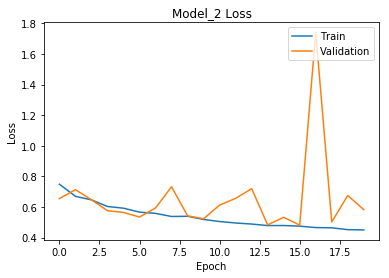

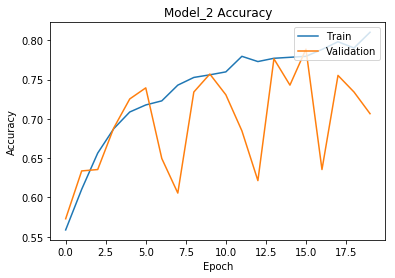

' \nResults:\n    The new model seems to suffer from overfitting despite adding in new layers\n    such as BatchNormalization and dropout. \n    Many different combinations were attempted and different sized conv2d layers\n    such as 512, but they were left out in the final model due to the hit to \n    performance. \n    With no time constraint more parameters could be explored and the model could\n    be trained on a higher number of epochs.\n    Next time a learning rate method could be employed to end the epoch cycle if \n    only little improvement is seen. \n'

In [5]:
# Add your code here


""" Building the improved CNN """
# Bulding an improved CNN using 4 stacks. 

# CNN is initialised
classifier = Sequential()

# 1st stack in CNN
classifier.add(Conv2D(32, (3, 3), input_shape=img_shape))  # covolution layer
classifier.add(BatchNormalization())  # helps prevent overfitting 
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling layer
classifier.add(Dropout(0.25))  # randomly drops features to help avoid overfitting

# 2nd stack
classifier.add(Conv2D(64, (3, 3)))
classifier.add(BatchNormalization())
classifier.add(Activation("relu"))
classifier.add(Conv2D(64, (3, 3)))
classifier.add(BatchNormalization())
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))


# 3rd stack
classifier.add(Conv2D(128, (3, 3)))
classifier.add(BatchNormalization())
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))


# 4th stack
classifier.add(Conv2D(256, (3, 3)))
classifier.add(BatchNormalization())
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))

# Flatten
classifier.add(Flatten())

# Fully connected
classifier.add(Dense(512)) 
classifier.add(Activation("relu"))
classifier.add(Dropout(0.5))
classifier.add(Dense(128)) 
classifier.add(Activation("relu"))
classifier.add(Dropout(0.5))
classifier.add(Dense(1))
classifier.add(Activation("sigmoid"))

# Compile
classifier.compile(optimizer = "rmsprop", loss = 'binary_crossentropy', metrics = ['accuracy'])


""" Data Augmentation """
# Generates new images that are altered to prevent overfitting

# Training data will use this 
train_img_gen = ImageDataGenerator(
        rescale = 1./255,  # resizes
        shear_range = 0.2,  # 
        zoom_range = 0.2,
        horizontal_flip = True
        )

# Validation and test data will use this
test_img_gen = ImageDataGenerator(rescale = 1./255)  # Only need to rescale

# Train images generated
train_gen = train_img_gen.flow_from_dataframe(
        dataframe = train,
        directory = None,
        x_col = "filename",
        y_col = "Label",
        target_size = (img_width, img_height),
        class_mode = "binary",
        seed = SEED
        )

# Validation images generated
val_gen = test_img_gen.flow_from_dataframe(
        dataframe = val,
        directory = None,
        x_col = "filename",
        y_col = "Label",
        target_size = (img_width, img_height),
        class_mode = "binary",
        seed = SEED
        )

# Test images generated
test_gen = test_img_gen.flow_from_dataframe(
        dataframe = test,
        directory = None,
        x_col = "filename",
        y_col = "Label",
        target_size = (img_width, img_height),
        class_mode = "binary",
        shuffle = False,
        batch_size = 1
        )


""" Fitting improved model """
# Fitting improved model using training data and validating it on validation data

model_2 = classifier.fit_generator(
        train_gen,
        epochs = 20,  # fine for this project
        steps_per_epoch = len(train_gen.filenames) // batch,  # set as advised by keras manual 
        validation_data = val_gen,
        validation_steps = len(val_gen.filenames) // batch,  # set as advised by keras manual
        shuffle = False
        )


""" Train and validation loss curves for improved model """

plt.plot(model_2.history['loss'])
plt.plot(model_2.history['val_loss'])
plt.title('Model_2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


""" Train and validation accuracy curves for improved model """

plt.plot(model_2.history['acc'])
plt.plot(model_2.history['val_acc'])
plt.title('Model_2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


""" 
Results:
    The new model seems to suffer from overfitting despite adding in new layers
    such as BatchNormalization and dropout. 
    Many different combinations were attempted and different sized conv2d layers
    such as 512, but they were left out in the final model due to the hit to 
    performance. 
    With no time constraint more parameters could be explored and the model could
    be trained on a higher number of epochs.
    Next time a learning rate method could be employed to end the epoch cycle if 
    only little improvement is seen. 
"""


### Exercise 5

Apply the trained model on the testing set and output the classification results.

G:\Software\Python\anaconda_dist\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
G:\Software\Python\anaconda_dist\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Printing classification results on test set 

Improved accuracy on test set is:  0.7166666666666667 

Classification report:  

              precision    recall  f1-score   support

           0       0.83      0.54      0.65       297
           1       0.66      0.89      0.76       303

   micro avg       0.72      0.72      0.72       600
   macro avg       0.75      0.71      0.71       600
weighted avg       0.75      0.72      0.71       600

Confusion Matrix:  

[[160 137]
 [ 33 270]]


G:\Software\Python\anaconda_dist\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


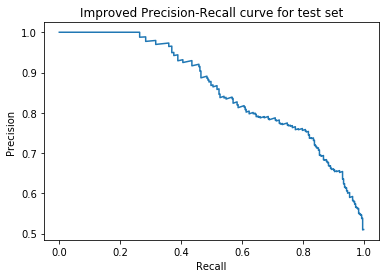

In [6]:
# Add your code here

""" Fetching predictions on test set """

# generating predictions 
preds2 = classifier.predict_generator(
        test_gen,
        steps = len(test_gen.filenames)
        )


""" Adding predictions to test dataframe """

# adding predictions to test df
test["probs2"] = preds2

# threshold to determine where predication is cat or dog
threshold = 0.5

# transforming prediction into readable labels to compare with labels column
test['preds2'] = np.where(test['probs2'] > threshold, "1","0")


""" Classification results on test set """

print("Printing classification results on test set", "\n")

### accuracy score ###
score = accuracy_score(test["Label"], test["preds2"])
print("Improved accuracy on test set is: ", score, "\n")

# Gave accuracy of ~ 0.8. Which is an improvement over the initial model
# approx 10% more accurate 

### classification report ###
print("Classification report: ", "\n")
print(classification_report(test["Label"], test["preds2"]))

# Cat f1 score = 0.79. This is good 
# Dog f1 score = 0.80. This is really good.
# Overall improved f1 scores

### confusion matrix ###
print("Confusion Matrix: ", "\n")
print(confusion_matrix(test["Label"], test["preds2"], labels=["0", "1"]))

### precision recall ###
test["binary_labels"] = test["Label"].map({'1': 1, '0': 0})  # Converting labels from string to binary format

precision, recall, _ = precision_recall_curve(test["binary_labels"], test["probs2"])  # generating values for plot

# plotting the curve
plt.plot(recall, precision)  
plt.title('Improved Precision-Recall curve for test set')
plt.xlabel('Recall')
plt.ylabel('Precision ')
plt.show()

# curve is looking normal and improved over the previous model as it contains
# a bigger area under the curve. 


### Exercise 6 

Plot the saliency map of original image to see which part is important for making classification decisions. You can refer to the following blog article on how to generate visualisation results of the filters in the ConvNets.
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [7]:
# Add your code here
